In [10]:
import logging
import argparse
from pathlib import Path
import math
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import yaml
import numpy as np

from gluonts.dataset.loader import TrainDataLoader
from gluonts.itertools import Cached
from gluonts.torch.batchify import batchify
from gluonts.time_feature import (
    time_features_from_frequency_str,
)

from uncond_ts_diff.utils import (
    create_transforms,
    create_splitter,
    get_next_file_num,
    add_config_to_argparser,
)
from uncond_ts_diff.custom_dataset import get_custom_dataset
from gbm import estimate_parameters
from scipy.fftpack import dct, idct



In [11]:
from gbm import estimate_parameters
import seaborn as sns

plt.style.use('seaborn')

/tmp/ipykernel_2820751/4159946292.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [12]:
# def sample_real(
#     data_loader,
#     n_timesteps: int,
#     num_samples: int = 10_000,
#     batch_size: int = 1000,
# ):
#     real_samples = []
#     data_iter = iter(data_loader)
#     n_iters = math.ceil(num_samples / batch_size)
#     for _ in tqdm(range(n_iters)):
#         try:
#             batch = next(data_iter)
#         except StopIteration:
#             data_iter = iter(data_loader)
#             batch = next(data_iter)
#         ts = batch['target'][:, -n_timesteps:]
#         real_samples.append(ts)

#     real_samples = np.concatenate(real_samples, axis=0)[:num_samples]

#     return real_samples

def sample_real(
    data_loader,
    n_timesteps: int,
    num_samples: int = 10_000,
    batch_size: int = 1000,
):
    real_samples = []
    data_iter = iter(data_loader)
    n_iters = math.ceil(num_samples / batch_size)
    for _ in tqdm(range(n_iters)):
        try:
            batch = next(data_iter)
        except StopIteration:
            data_iter = iter(data_loader)
            batch = next(data_iter)
        ts = np.concatenate(
            [batch["past_target"], batch["future_target"]], axis=-1
        )[:, -n_timesteps:]
        real_samples.append(ts)

    real_samples = np.concatenate(real_samples, axis=0)[:num_samples]

    return real_samples


def plot_gbm(St, n, M, dt):
    time = np.linspace(0, n * dt, St.shape[0])
    tt = np.full(shape=(M, St.shape[0]), fill_value=time).T
    plt.plot(tt, St)
    plt.xlabel("Years $(t)$")
    plt.ylabel("Stock Price $(S_t)$")
    plt.show()

In [13]:
config = {
    "dataset_path": "../data/exp1/gbm-0.jsonl",
    "context_length": 197,
    "prediction_length": 1,
    "n": 200
}

context_length = config["context_length"]
prediction_length = config["prediction_length"]

dataset = get_custom_dataset(config['dataset_path'], 'D', prediction_length)
config["freq"] = dataset.metadata.freq
assert prediction_length == dataset.metadata.prediction_length




In [14]:
dataset

TrainDatasets(metadata=MetaData(freq='D', target=None, feat_static_cat=[], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=1), train=TrainingDataset(dataset=Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f75042eb820>, iterable=JsonLinesFile(path=PosixPath('../data/exp1/gbm-0.jsonl'), start=0, n=None)), splitter=OffsetSplitter(offset=-1)), test=Map(fn=<gluonts.dataset.common.ProcessDataEntry object at 0x7f75042eb820>, iterable=JsonLinesFile(path=PosixPath('../data/exp1/gbm-0.jsonl'), start=0, n=None)))

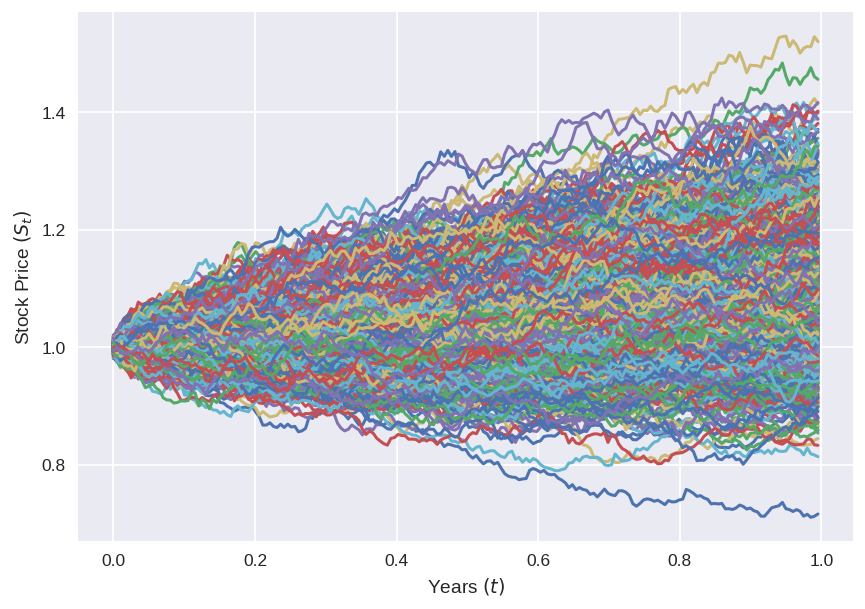

In [15]:
st = np.array([item['target'] for item in list(dataset.train)])
st = st.T
plot_gbm(st, st.shape[0], st.shape[1], 1/config["n"])

<Axes: ylabel='Density'>

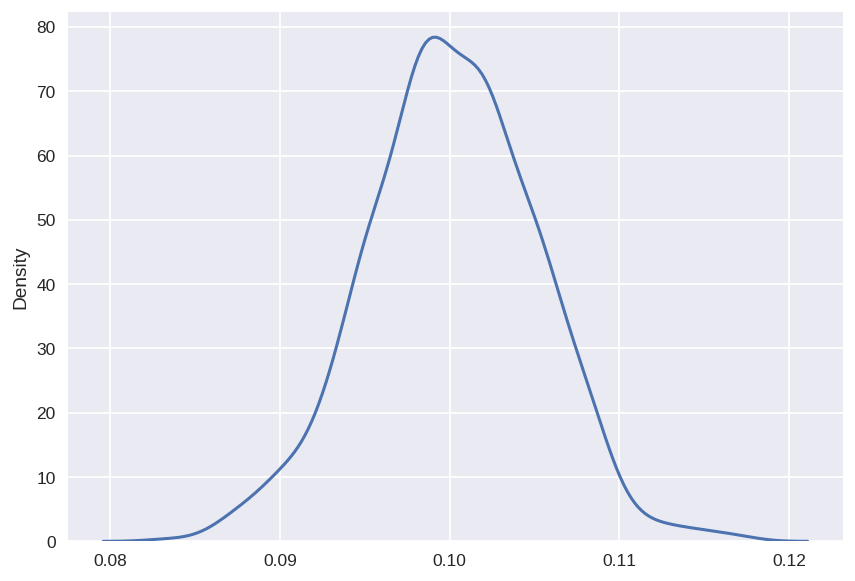

In [16]:
params = estimate_parameters(st, 1/config["n"], ret_distribution=True)
sns.kdeplot(params[0])

<Axes: ylabel='Density'>

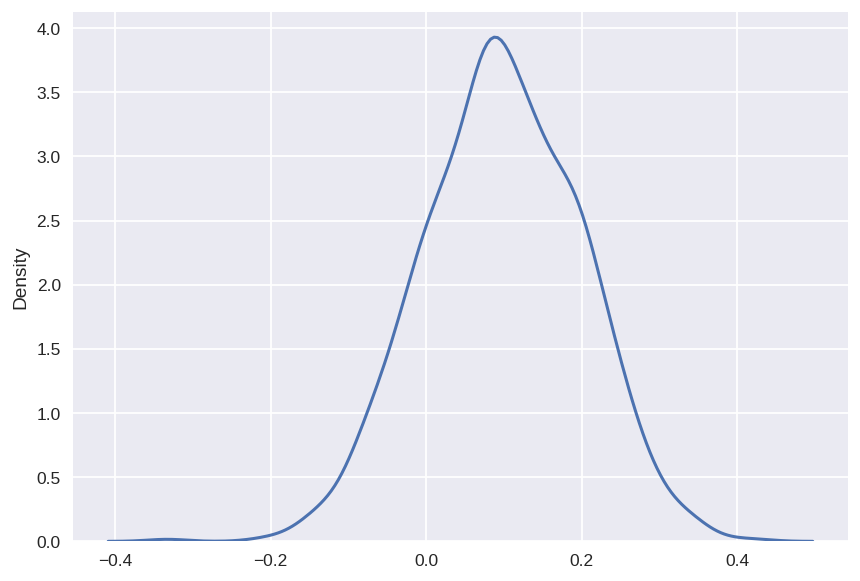

In [17]:
sns.kdeplot(params[1])

In [18]:
st.shape

(199, 1000)

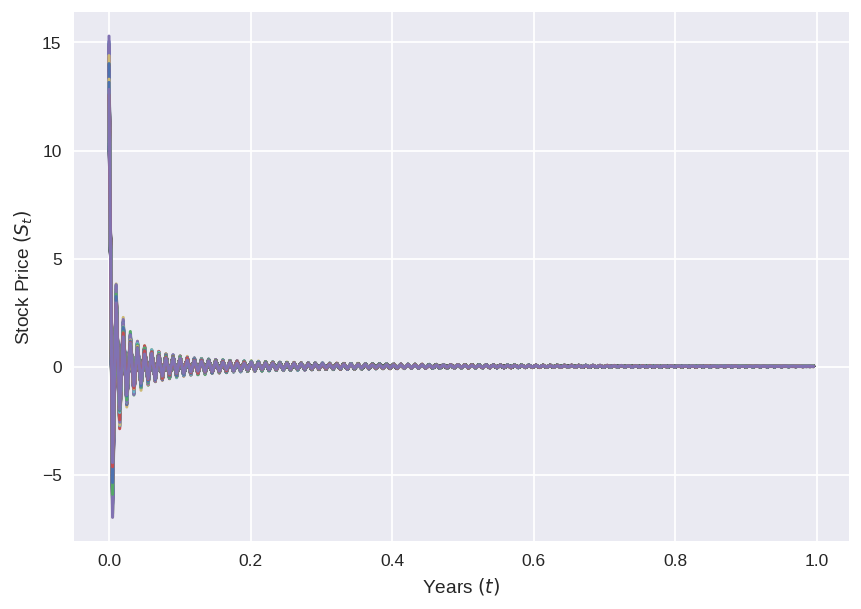

In [19]:
plot_gbm(
    idct(st, norm='ortho', axis=0),
    st.shape[0],
    st.shape[1],
    1/config["n"]
)

In [20]:
# Setup data transformation and loading
transformation = create_transforms(
    num_feat_dynamic_real=0,
    num_feat_static_cat=0,
    num_feat_static_real=0,
    time_features=time_features_from_frequency_str(config["freq"]),
    prediction_length=prediction_length,
)
transformed_data = transformation.apply(list(dataset.train), is_train=True)
training_splitter = create_splitter(
    past_length=context_length,
    future_length=prediction_length,
    mode="train",
)
train_dataloader = TrainDataLoader(
    Cached(transformed_data),
    batch_size=1000,
    stack_fn=batchify,
    transform=training_splitter,
)

print()



In [21]:
transformed_data

In [22]:
# next(iter(train_dataloader))['target'].shape

In [23]:
# Generate real samples
real_samples = sample_real(
    train_dataloader,
    n_timesteps=context_length + prediction_length,
    num_samples=10000,
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [24]:
real = real_samples.T

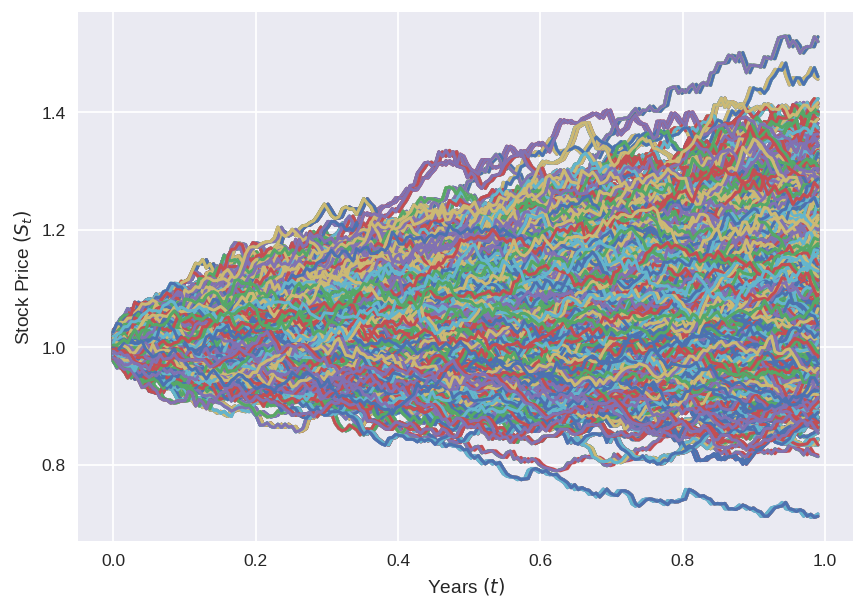

In [25]:
plot_gbm(real, real.shape[0], real.shape[1], 1/config["n"])

<Axes: ylabel='Density'>

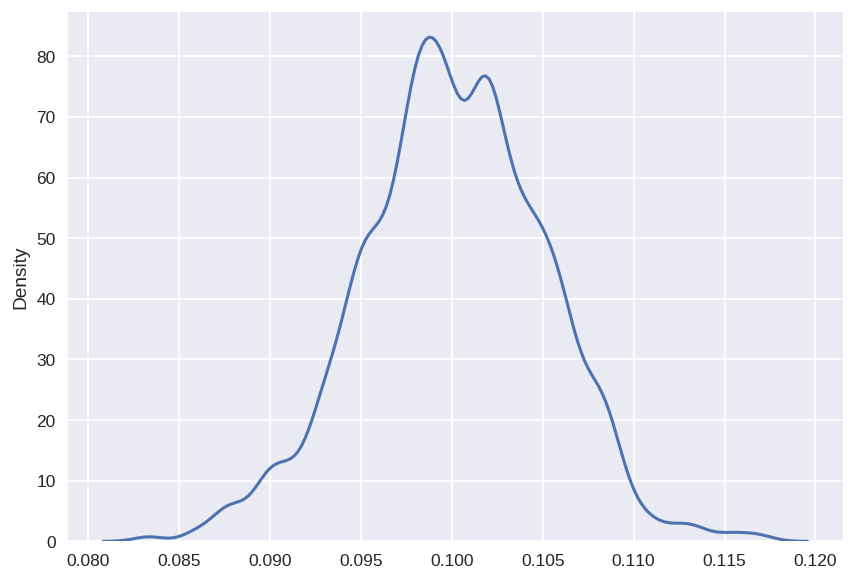

In [26]:
params = estimate_parameters(real, 1/config["n"], ret_distribution=True)
sns.kdeplot(params[0])

<Axes: ylabel='Density'>

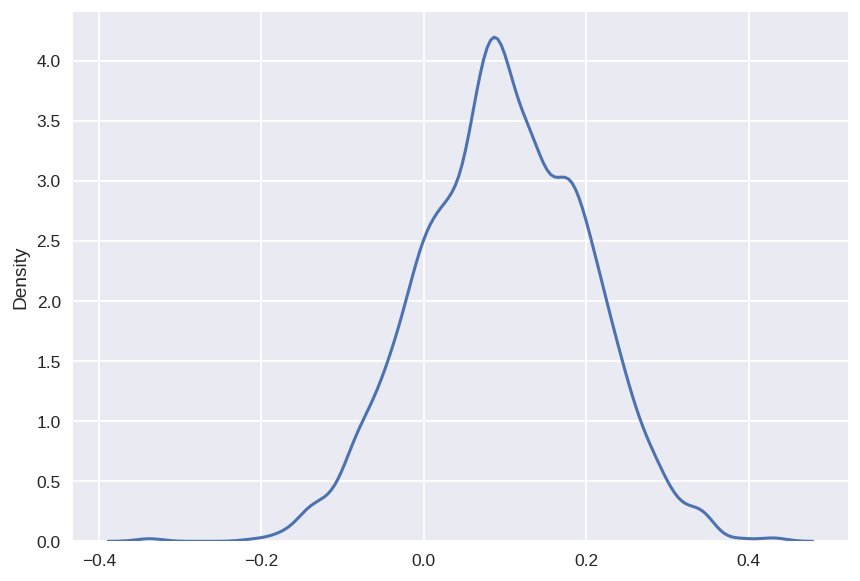

In [27]:
sns.kdeplot(params[1])

In [28]:
real.shape

(198, 10000)

In [29]:
np.allclose(real[:, 0], real[:, 200])

False

In [30]:
restored = dct(real, axis=0, norm='ortho')

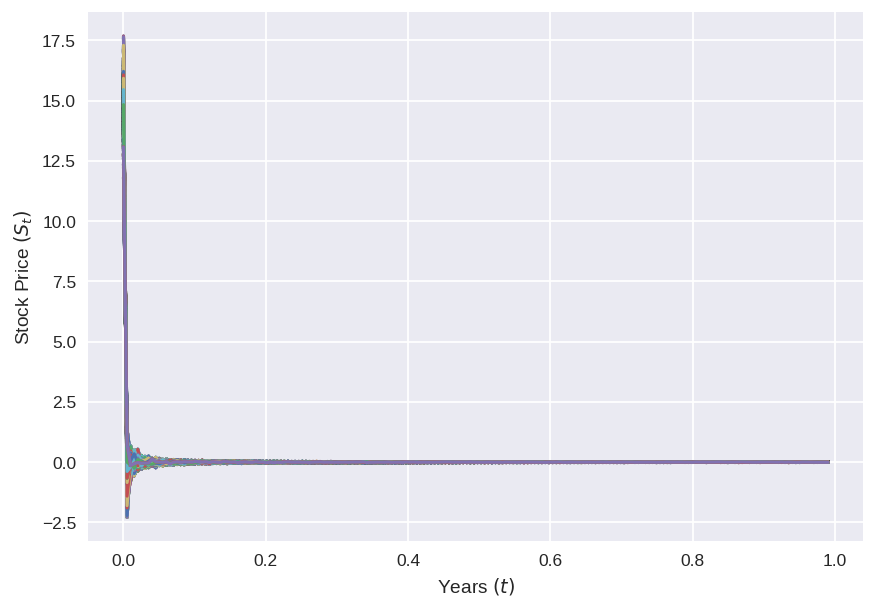

In [31]:
plot_gbm(restored, restored.shape[0], restored.shape[1], 1/config["n"])

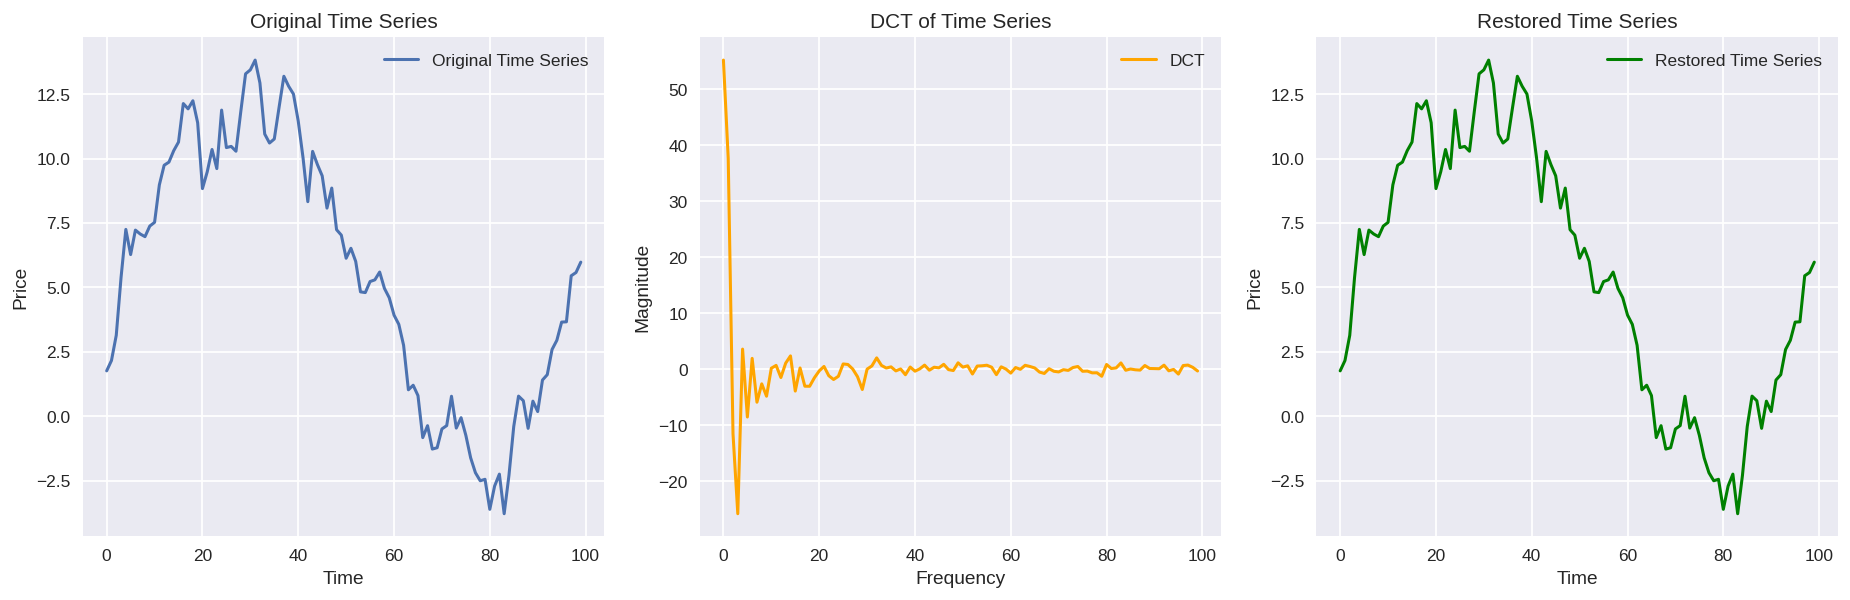

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# Generate a time series that resembles stock prices using a random walk
np.random.seed(0)
n = 100  # Length of the time series
time_series = np.cumsum(np.random.randn(n))  # Random walk

# Apply the Discrete Cosine Transform (DCT)
dct_series = dct(time_series, norm='ortho')

# Restore the sequence using the inverse DCT
restored_series = idct(dct_series, norm='ortho')

# Plot the original time series, DCT, and restored sequence
plt.figure(figsize=(15, 5))

# Original time series
plt.subplot(1, 3, 1)
plt.plot(time_series, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# DCT of the time series
plt.subplot(1, 3, 2)
plt.plot(dct_series, label='DCT', color='orange')
plt.title('DCT of Time Series')
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.legend()

# Restored time series
plt.subplot(1, 3, 3)
plt.plot(restored_series, label='Restored Time Series', color='green')
plt.title('Restored Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


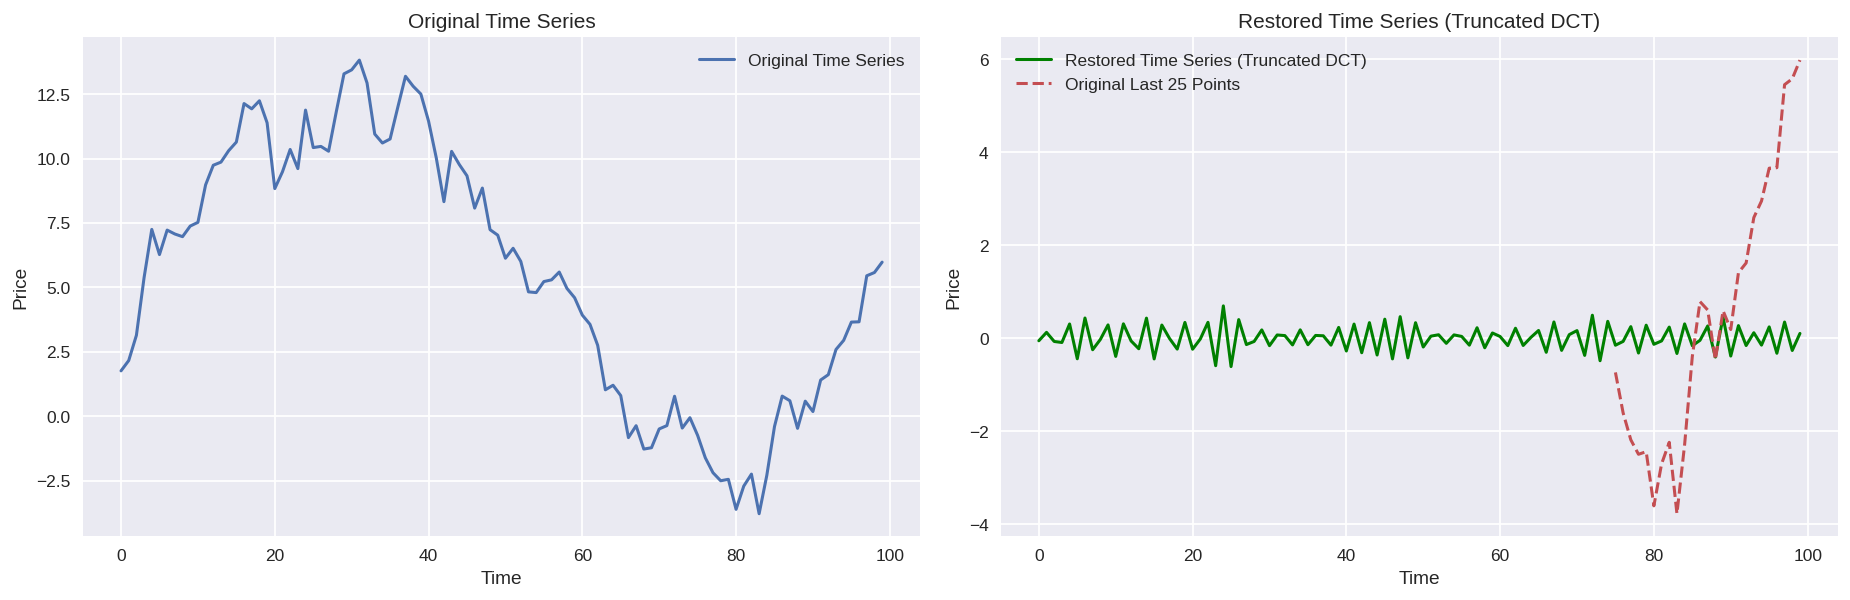

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# Generate a time series that resembles stock prices using a random walk
np.random.seed(0)
n = 100  # Length of the time series
time_series = np.cumsum(np.random.randn(n))  # Random walk

# Apply the Discrete Cosine Transform (DCT)
dct_series = dct(time_series, norm='ortho')

# Retain only the last 25 DCT coefficients
truncated_dct_series = np.zeros_like(dct_series)
truncated_dct_series[-25:] = dct_series[-25:]

# Restore the sequence using the inverse DCT on the truncated DCT sequence
restored_series_truncated = idct(truncated_dct_series, norm='ortho')

# Plot the original time series, truncated DCT restoration, and compare with the original last 25 points
plt.figure(figsize=(15, 5))

# Original time series
plt.subplot(1, 2, 1)
plt.plot(time_series, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Restored time series from truncated DCT
plt.subplot(1, 2, 2)
plt.plot(restored_series_truncated, label='Restored Time Series (Truncated DCT)', color='green')
plt.plot(range(n-25, n), time_series[-25:], 'r--', label='Original Last 25 Points')
plt.title('Restored Time Series (Truncated DCT)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


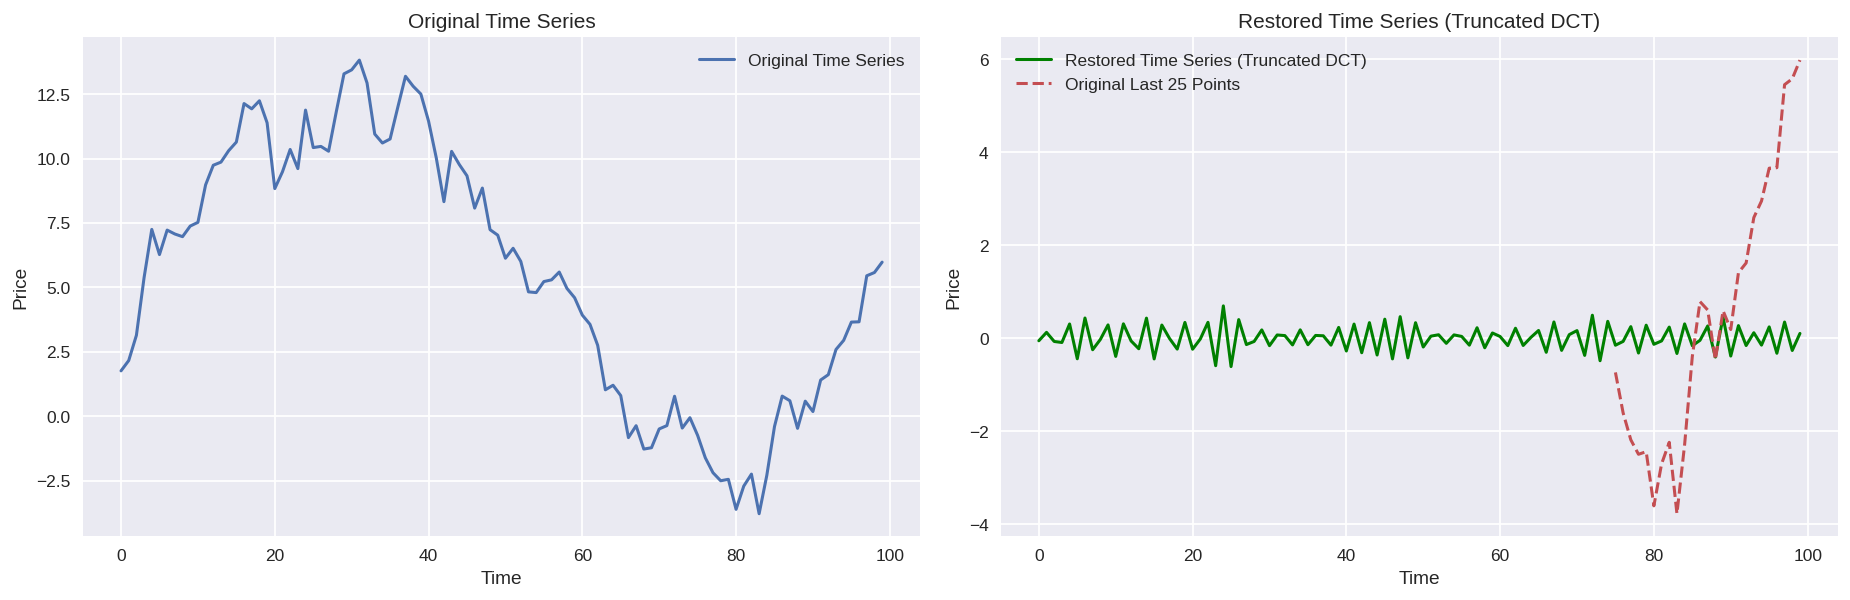

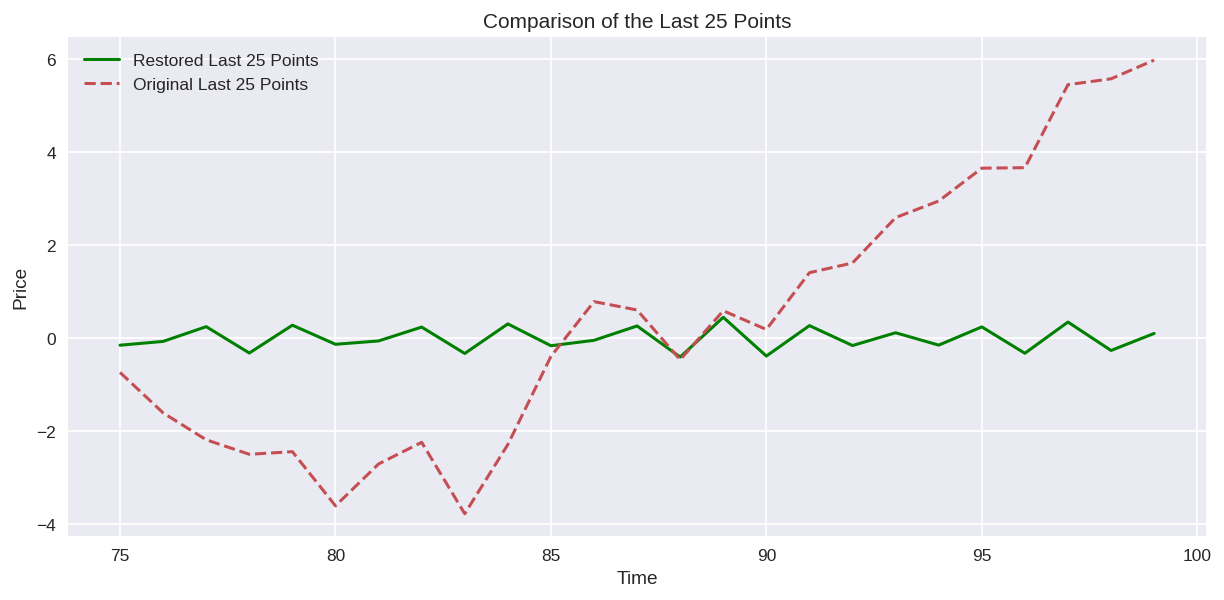

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# Generate a time series that resembles stock prices using a random walk
np.random.seed(0)
n = 100  # Length of the time series
time_series = np.cumsum(np.random.randn(n))  # Random walk

# Apply the Discrete Cosine Transform (DCT)
dct_series = dct(time_series, norm='ortho')

# Retain only the last 25 DCT coefficients
truncated_dct_series = np.zeros_like(dct_series)
truncated_dct_series[-25:] = dct_series[-25:]

# Restore the sequence using the inverse DCT on the truncated DCT sequence
restored_series_truncated = idct(truncated_dct_series, norm='ortho')

# Plot the original time series, truncated DCT restoration, and compare with the original last 25 points
plt.figure(figsize=(15, 5))

# Original time series
plt.subplot(1, 2, 1)
plt.plot(time_series, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Restored time series from truncated DCT
plt.subplot(1, 2, 2)
plt.plot(restored_series_truncated, label='Restored Time Series (Truncated DCT)', color='green')
plt.plot(range(n-25, n), time_series[-25:], 'r--', label='Original Last 25 Points')
plt.title('Restored Time Series (Truncated DCT)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

# Zoom in on the last 25 points
plt.figure(figsize=(10, 5))
plt.plot(range(n-25, n), restored_series_truncated[-25:], label='Restored Last 25 Points', color='green')
plt.plot(range(n-25, n), time_series[-25:], 'r--', label='Original Last 25 Points')
plt.title('Comparison of the Last 25 Points')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()


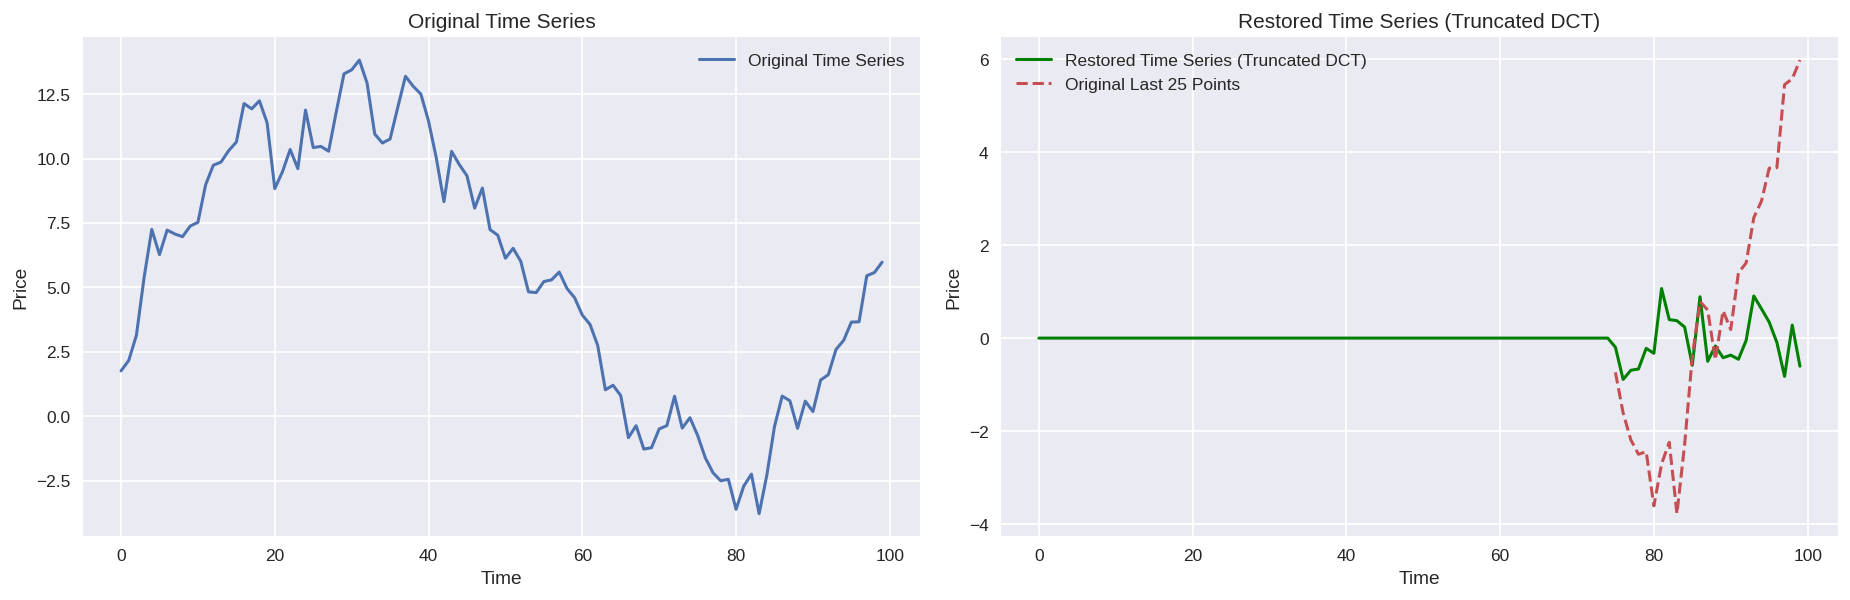

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct

# Generate a time series that resembles stock prices using a random walk
np.random.seed(0)
n = 100  # Length of the time series
time_series = np.cumsum(np.random.randn(n))  # Random walk

# Apply the Discrete Cosine Transform (DCT)
dct_series = dct(time_series, norm='ortho')

# Retain only the last 25 DCT coefficients
truncated_dct_series = dct_series[-25:]

# Restore the sequence using the inverse DCT on the truncated DCT sequence
restored_series_truncated = np.zeros_like(time_series)
restored_series_truncated[-25:] = idct(truncated_dct_series, norm='ortho')

# Plot the original time series, truncated DCT restoration, and compare with the original last 25 points
plt.figure(figsize=(15, 5))

# Original time series
plt.subplot(1, 2, 1)
plt.plot(time_series, label='Original Time Series')
plt.title('Original Time Series')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

# Restored time series from truncated DCT
plt.subplot(1, 2, 2)
plt.plot(restored_series_truncated, label='Restored Time Series (Truncated DCT)', color='green')
plt.plot(range(n-25, n), time_series[-25:], 'r--', label='Original Last 25 Points')
plt.title('Restored Time Series (Truncated DCT)')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()
